In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import spatial
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *

# Neural Data AIC

### Load Some Data

In [20]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'

In [21]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [22]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [23]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
# areas = np.hstack([areas, 'all'])

In [25]:
# sample times
# sample_nums = {'pre': 4, 'induction': 1, 'during': 4, 'post':2}
sample_nums = {'pre': 1, 'induction': 0, 'during': 1, 'post':0}
sample_ts = np.zeros(np.sum([num for num in sample_nums.values()]))
loc = 0
for key, section_bounds in section_times.items():
    sample_ts[loc:loc + sample_nums[key]] = np.random.uniform(section_bounds[0]*1.1, section_bounds[1]*0.9, size=(sample_nums[key],))
    loc += sample_nums[key]
sample_ts.sort()

# Load Directory

In [26]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

# Load Data

In [27]:
areas = ['vlPFC']

In [28]:
# area = 'vlPFC'
area_signals = {}
signal_duration = 45 # seconds
iterator = tqdm(total=len(areas)*len(sample_ts))
for area in areas:
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    
    signals = {}
    for sample_t in sample_ts:
        signals[f"t={sample_t}"] = load_window_from_chunks(sample_t, sample_t + signal_duration, directory, unit_indices)
        iterator.update()
    area_signals[area] = signals

iterator.close()

  0%|          | 0/2 [00:00<?, ?it/s]

# Analyze

In [29]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp'
save_path = os.path.join(save_dir, f"{session}_{area}_grid_search")

In [41]:
use_torch = True
device = 'cpu'
dtype='torch.DoubleTensor'
verbose = True

In [42]:
parameter_grid = ParameterGrid(
    window_vals=np.array([15000]),
#     matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000]),
    matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000]),
#     r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]),
    r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000]),
    reseed=False
)

transient = 0

start_ind = np.argmax(parameter_grid.matrix_size_vals > np.max([signal.shape[1] for signal in signals.values()])) - 1
matrix_size_vals = parameter_grid.matrix_size_vals[start_ind:]
prediction_time = int(10/dt)

In [43]:
area_signal_results = {}
for area, signals in area_signals.items():
    signal_results = {}
    for key, signal in signals.items():
        train_signal = signal[:parameter_grid.window_vals[0]]
        test_signal = signal[parameter_grid.window_vals[0]:parameter_grid.window_vals[0] + prediction_time]
        signal_results[key] = parameter_search(train_signal, test_signal, parameter_grid, dt, use_torch=use_torch, device=device, dtype=dtype, verbose=verbose)
    
    area_signal_results[area] = signal_results

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

In [33]:
AIC = np.zeros((len(parameter_grid.matrix_size_vals), len(parameter_grid.r_vals)))
counts = np.zeros(AIC.shape)
stab_curves = {}
for key, results in signal_results.items():
    for i, matrix_size in enumerate(parameter_grid.matrix_size_vals):
        for j, r in enumerate(parameter_grid.r_vals):
            row = results[np.logical_and(results.matrix_size == matrix_size, results.r == r)]
            if len(row) >= 1:
                row = row.iloc[0]
                AIC[i, j] = row.AIC
                counts[i, j] += 1
                
                if (matrix_size, r) not in stab_curves.keys():
                    stab_curves[(matrix_size, r)] = {}
                stab_curves[(matrix_size, r)][key] = row.stability_params
                
            else:
                AIC[i, j] = np.Inf
counts[counts == 0] = 1
AIC /= counts
#             r_vals[i, j] = row.r
#             if mean_stab_curve:
#                 stab_curve[(matrix_size, r)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves.values()])
#             else:
#                 if use_torch:
#                     stab_curve[(matrix_size, r)] = [curve[:int(top_percent*len(curve))].numpy() for curve in row.stab_curves.values()]
#                 else:
#                     stab_curve[(matrix_size, r)] = [curve[:int(top_percent*len(curve))] for curve in row.stab_curves.values()]

In [34]:
m_index, t_index = np.unravel_index(AIC.argmin(), shape=AIC.shape)

In [35]:
picked_color = 'orange'

In [36]:
AIC[AIC == np.Inf] = np.nan

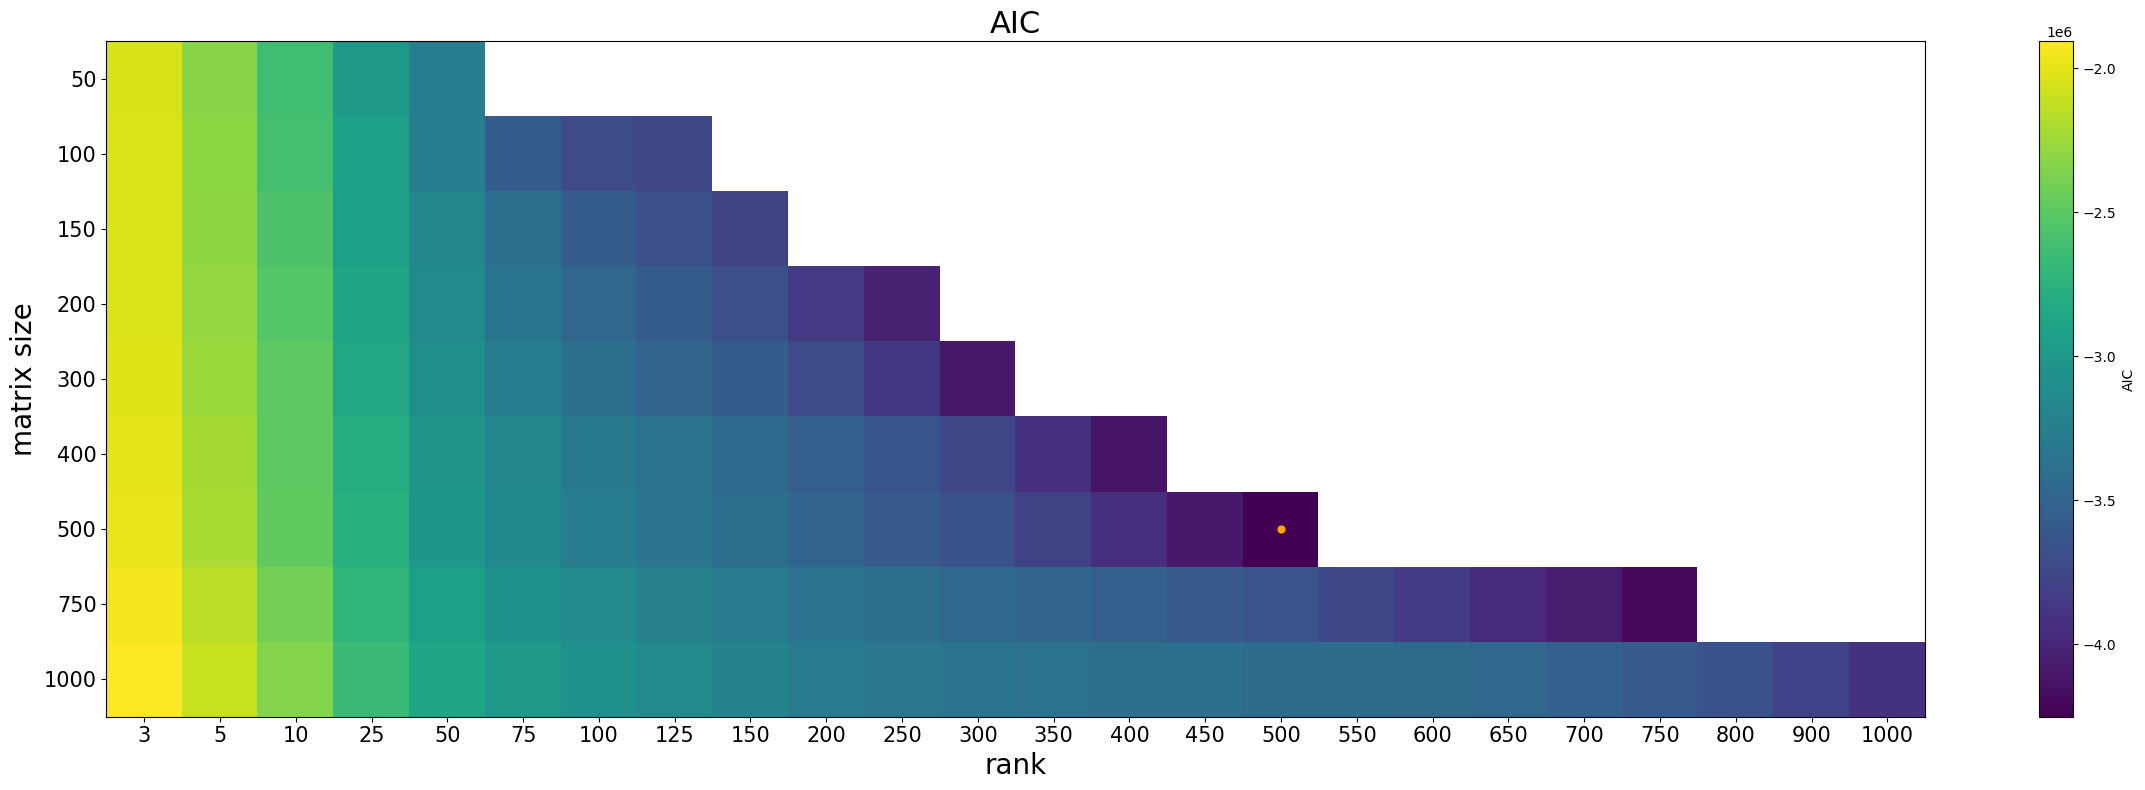

In [37]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=AIC[~np.isnan(AIC)].min(),vmax=AIC[~np.isnan(AIC)].max())

plt.imshow(AIC, norm=norm, aspect='auto')
plt.yticks(np.arange(len(parameter_grid.matrix_size_vals)), [f"{matrix_size}" for matrix_size in parameter_grid.matrix_size_vals])
plt.ylabel("matrix size", fontsize=20)
plt.xticks(np.arange(len(parameter_grid.r_vals)), [f"{r}" for r in parameter_grid.r_vals])
plt.xlabel('rank', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=15)
ax.set_title(f'AIC', fontsize=22)
ax.scatter(t_index, m_index, c=picked_color, s=24)
plt.colorbar(ax=ax, label='AIC')

plt.tight_layout()
plt.show()

In [38]:
top_percent = 0.2
mean_stab_curve = False
key_inds = np.arange(len(results.keys()))
keys = results.keys()

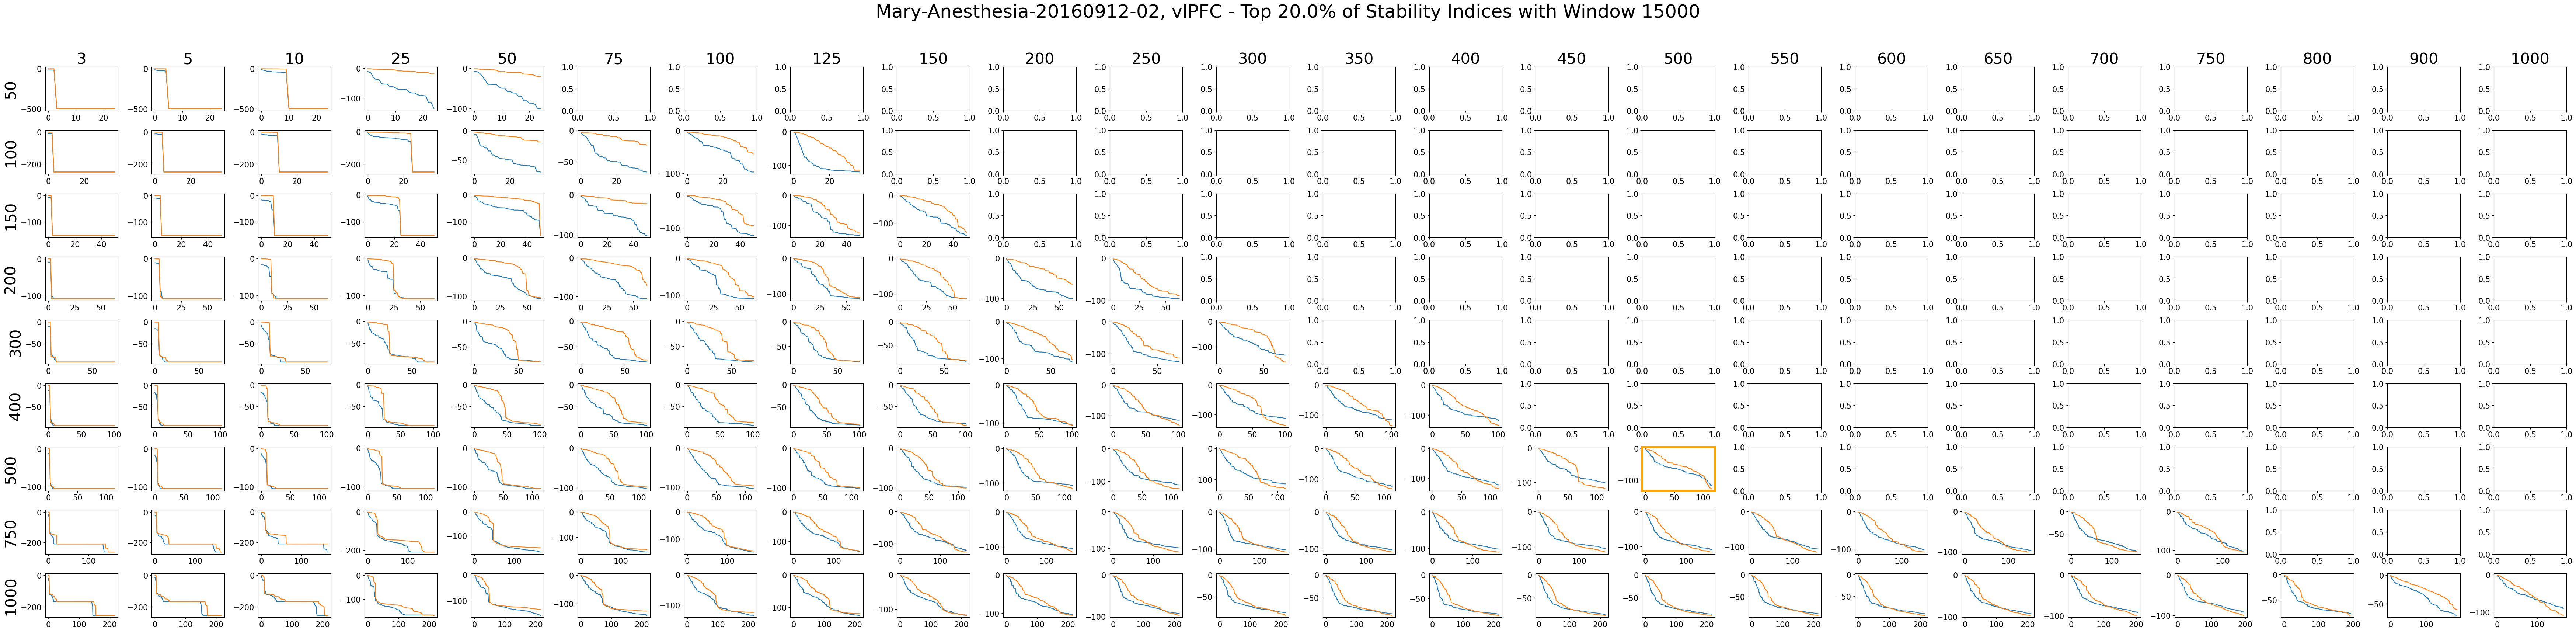

In [39]:
title_size = 30
label_size = 15
%matplotlib inline
fig, axs = plt.subplots(len(parameter_grid.matrix_size_vals), len(parameter_grid.r_vals), figsize=(70, 18))
for i, r in enumerate(parameter_grid.r_vals):
    for j, matrix_size in enumerate(parameter_grid.matrix_size_vals):
        ax = axs[j][i]
        if (matrix_size, r) in stab_curves.keys():
            if mean_stab_curve:
                ax.plot(keys[key_inds], stab_curve[(matrix_size, r)][key_inds])
                ax2 = ax.twinx()
                ax2.plot(keys[key_inds], true_vals, linestyle='--', c='k')

                ax2.tick_params(labelsize=label_size)
                if j == m_index and i == t_index:
                    for spine in ax2.spines.values():
                        spine.set_color(picked_color)
                        spine.set_linewidth(6)
            else:
                for key, curve in stab_curves[(matrix_size, r)].items():
                    ax.plot(curve[:int(top_percent*len(curve))])
                
        if j == 0:
            ax.set_title(f'{r}', fontsize=title_size)
        if i == 0:
            ax.set_ylabel(f'{matrix_size}', fontsize=title_size)
        ax.tick_params(labelsize=label_size)
            
        if j == m_index and i == t_index:
            for spine in ax.spines.values():
                spine.set_color(picked_color)
                spine.set_linewidth(4)
            
#                 ax.spines['bottom'].set_color(picked_color)
#                 ax.spines['top'].set_color(picked_color) 
#                 ax.spines['right'].set_visible(False)
#                 ax.spines['left'].set_color(picked_color)

#                 ax2.spines['bottom'].set_color(picked_color)
#                 ax2.spines['top'].set_color(picked_color) 
#                 ax2.spines['right'].set_color(picked_color)
#                 ax2.spines['left'].set_visible(False)
            
        
plt.suptitle(f'{session}, {area} - Top {top_percent*100}% of Stability Indices with Window {parameter_grid.window_vals[0]}', fontsize=36)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

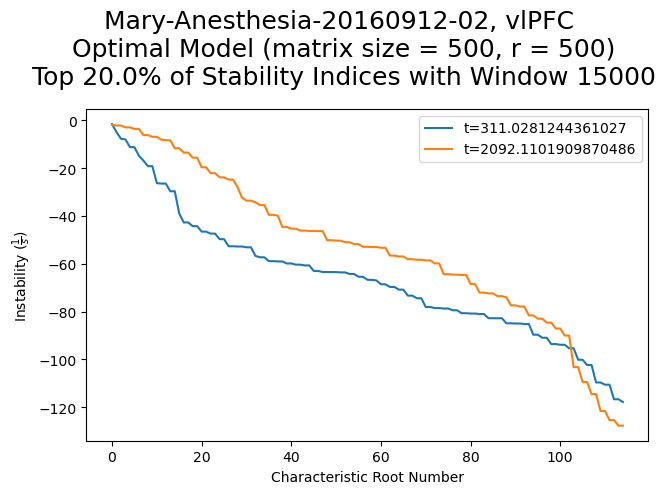

In [40]:
for key in signals.keys():
    curve = stab_curves[(parameter_grid.matrix_size_vals[m_index], parameter_grid.r_vals[t_index])][key]
    plt.plot(curve[:int(top_percent*len(curve))], label=key)
plt.suptitle(f'{session}, {area} \nOptimal Model (matrix size = {parameter_grid.matrix_size_vals[m_index]}, r = {parameter_grid.r_vals[t_index]})\nTop {top_percent*100}% of Stability Indices with Window {parameter_grid.window_vals[0]}', fontsize=18)
plt.legend()
plt.tight_layout()
plt.xlabel('Characteristic Root Number')
plt.ylabel(r'Instability ($\frac{1}{s}$)')
plt.show()